# Imports

In [49]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
from tqdm.auto import tqdm
from tqdm import trange
import itertools
import os

from utility import load_pickle, save_pickle, show_mel

# Resources

Model design and training made following Albadawi 2020, and some open source github repos and tutorials:
- https://github.com/liusongxiang/StarGAN-Voice-Conversion/blob/master/model.py
- https://github.com/pritishyuvraj/Voice-Conversion-GAN/blob/master/model.py
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://github.com/Lornatang/CycleGAN-PyTorch/blob/master/cyclegan_pytorch/models.py
- https://github.com/seangal/dcgan_vae_pytorch/blob/master/main.py

# Models

Creating the residual block for the encoder. Instance norm 2d normalises samples with respect to them self rather than all neighbouring samples in a batch (as is done in batch normalization).

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, dim_in):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ReflectionPad2d(2),
            nn.Conv2d(dim_in, dim_in, kernel_size=4, bias=False),
            nn.InstanceNorm2d(dim_in),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.conv2 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim_in, dim_in, kernel_size=4, bias=False),
            nn.InstanceNorm2d(dim_in))
        
        
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        return x + y

The rational for the encoder is to rid of all the non-timbral related information in its dimensionality reduction to the latent space. The generator then builds up the new voice from the rich latent space.

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # Initial linear convolutional mapping
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=7, bias=False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2))
        
        # Non-linear mapping convolutional layers
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, bias=False, stride=2), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2))
        
        self.conv3 =nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, bias=False, stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2))
        
        self.conv4 =nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, bias=False, stride=2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)) 
                 
        # Residual blocks with skip connections for bottleneck
        self.res5 = ResidualBlock(1024)
        self.mu6 = ResidualBlock(1024)
        self.logvar6 = ResidualBlock(1024)
        
        # OLD: Starting with less residual blocks due to memory
        # l.append(ResidualBlock(512, 1024))
        # l.append(ResidualBlock(1024, 1156))
        # l.append(ResidualBlock(1156, 1280)) 
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):     
        
        # Main layers
        x = self.conv1(x)      
        x = self.conv2(x)      
        x = self.conv3(x)        
        x = self.conv4(x)     
        x = self.res5(x)     
        
        # Bottleneck
        mu = self.mu6(x)
        logvar = self.logvar6(x)   
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

Following Albadawi 2020, making the generator the reverse of the encoder for upsampling in a decoder-like manner.

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.res1 = ResidualBlock(1024)  
        
        # OLD: Starting with less residual blocks due to memory
        # l.append(ResidualBlock(1156, 1024))
        # l.append(ResidualBlock(1024, 512)) 
        
        # Non-linear mapping convolutional layers
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, bias=False, stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2))
        
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, bias=False, stride=2), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2))
        
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, bias=False, stride=2), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2))
        
        # Final linear convolutional mapping 
        self.conv5 = nn.Sequential(
            nn.ConvTranspose2d(128, 1, kernel_size=11, bias=False), 
            nn.Tanh())  # wrt DCGAN
                
        
    def forward(self, x):
        x = self.res1(x)  
        x = self.conv2(x) 
        x = self.conv3(x) 
        x = self.conv4(x) 
        x = self.conv5(x) 
        return x

Discriminator is downsampling to a feature space for classification. Followed DCGAN intuition. Strided convolutions with ReLU based activations, and non strided convolution for the last fifth layer with a Sigmoid activation.

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, bias=False, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, bias=False, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, bias=False, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, bias=False, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True))
                
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=8, bias=False),
            nn.Sigmoid())  # wrt DCGAN

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x        

# Training

### Hyperparameters

In [6]:
# Training control
max_epochs = 50
max_duplets = 28 #3000
batch_size = 4
learning_rate = 0.0001

assert max_duplets % batch_size == 0, 'Max sample pairs must be divisible by batch size!' 

# Regularisation
lambda_cycle = 10.0

### Data

Loading data and shuffling it and converting to torch.

In [7]:
# Loading
melset_7_128 = load_pickle('pool/melset_7_128.pickle')
melset_4_128 = load_pickle('pool/melset_4_128.pickle')

In [8]:
print(len(melset_7_128), len(melset_4_128))

5160 3386


In [9]:
rng = np.random.default_rng()

# Shuffling melspectrograms
melset_7_128 = rng.permutation(np.array(melset_7_128))
melset_4_128 = rng.permutation(np.array(melset_4_128))

# Torch conversion
melset_7_128 = torch.from_numpy(melset_7_128)
melset_4_128 = torch.from_numpy(melset_4_128)

### Model Instantiation

Following Albadawi 2020, unlike the other models, there is only one universal encoder in attempt to train it to rid of frequency and loudness information across speakers.

The first residual block of each generator was common in Albadawi 2020. For simplicity, the first ecoding residual block is not individual to each decoder.

In [10]:
# Free up memory if models previously initialised
import gc
if 'E' in globals(): del E 
if 'G_A2B' in globals(): del G_A2B
if 'D_B' in globals(): del D_B 
if 'G_B2A' in globals(): del G_B2A
if 'D_A' in globals(): del D_A
torch.cuda.empty_cache()

device = 'cuda' # torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

# Shared encoder model (with partial decoding)
E = Encoder().to(device)

# Generator and Discriminator for Speaker A to B
G_A2B = Generator().to(device)
D_B = Discriminator().to(device)

# Generator and Discriminator for Speaker B to A
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)

### Training Utilities

Initialise weights from dist with mu=0, s=0.02

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
E.apply(weights_init)
G_A2B.apply(weights_init)
G_B2A.apply(weights_init)
D_A.apply(weights_init)
D_B.apply(weights_init)
print()

Keeping an experience roleplay buffer for training discriminator on previous iterations. 

In [13]:
import random

class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

In [14]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

### Objective Initialisation

MSE instead of BCE for adversarial loss making it a Least Squares GAN. Aims to minimize vanishing gradients by making it less discrete, done following CycleGAN implementation.

In [15]:
# Initialising optimizers
optim_E = torch.optim.Adam(E.parameters(), lr=learning_rate)
optim_G = torch.optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()),lr=learning_rate)
optim_D_A = torch.optim.Adam(D_A.parameters(), lr=learning_rate)
optim_D_B = torch.optim.Adam(D_B.parameters(), lr=learning_rate)

# Inializing criterions
loss_adversarial = torch.nn.MSELoss().to(device)
loss_cycle = torch.nn.L1Loss().to(device)

### Training loop

Training loop implemented based on Albadawi 2020 for theory and CycleGAN for implementation

In [84]:
pbar = tqdm(range(max_epochs), desc='Epochs')  # init epoch pbar

# Initialising loss history lists
train_hist = {}
train_hist['G_B2A'] = []
train_hist['G_ABA'] = []
train_hist['G_A2B'] = [] 
train_hist['G_BAB'] = [] 
train_hist['G'] = []
train_hist['D_A'] = []
train_hist['D_B'] = []
train_hist['VAE_A'] = []
train_hist['VAE_B'] = []

# Training loop
for i in pbar:
    
    pbar_sub = tqdm(range(0, max_duplets, batch_size),leave=False, desc='Batches')  # init batch pbar 
    
    for j in pbar_sub:
        
        # Loading real samples from each speaker in batches
        real_mel_A = melset_7_128[j * batch_size : (j * batch_size) + batch_size].to(device)
        real_mel_B = melset_4_128[j * batch_size : (j * batch_size) + batch_size].to(device)
        
        # Resizing to model tensors
        real_mel_A = real_mel_A.view(batch_size, 1, 128, 128)
        real_mel_B = real_mel_B.view(batch_size, 1, 128, 128)

        # Real data labelled 1, fake data labelled 0
        batch_size = real_mel_A.size(0)
        real_label = torch.squeeze(torch.full((batch_size, 1), 1, device=device, dtype=torch.float32))
        fake_label = torch.squeeze(torch.full((batch_size, 1), 0, device=device, dtype=torch.float32))
        
        # =====================================================
        #            Encoders and Decoding Generators update
        # =====================================================

        # Resetting gradients
        optim_E.zero_grad()
        optim_G.zero_grad()   

        # Forward pass for B to A
        latent_mel_A, mu_A, logvar_A = E(real_mel_A)
        fake_mel_A = G_B2A(latent_mel_A)
        fake_output_A = torch.squeeze(D_A(fake_mel_A))
        
        # Cyclic reconstuction from fake A to B
        latent_fake_A, mu_fake_A, logvar_fake_A = E(fake_mel_A)
        recon_mel_B = G_A2B(latent_fake_A)  
        
        # Forward pass for A to B
        latent_mel_B, mu_B, logvar_B = E(real_mel_B)
        fake_mel_B = G_A2B(latent_mel_B)
        fake_output_B = torch.squeeze(D_B(fake_mel_B))
        
        # Cyclic reconstuction from fake B to A
        latent_fake_B, mu_fake_B, logvar_fake_B = E(fake_mel_B)
        recon_mel_A = G_B2A(latent_fake_B)  
        
        # Encoding loss A and B
        kld_A = -0.5 * torch.sum(1 + logvar_A - mu_A.pow(2) - logvar_A.exp())
        mse_A = (recon_mel_A - real_mel_A).pow(2).mean()
        loss_VAE_A = kld_A + mse_A
        
        kld_B = -0.5 * torch.sum(1 + logvar_B - mu_B.pow(2) - logvar_B.exp())
        mse_B = (recon_mel_B - real_mel_B).pow(2).mean()
        loss_VAE_B = kld_B + mse_B
        
        errVAE = (loss_VAE_A + loss_VAE_B) / 2
        errVAE.backward(retain_graph=True)  # retain graph so other losses can update in same graph
        optim_E.step()
        
        # GAN loss
        loss_GAN_B2A = loss_adversarial(fake_output_A, real_label)
        loss_GAN_A2B = loss_adversarial(fake_output_B, real_label)
        
        # Cyclic loss
        loss_cycle_ABA = loss_cycle(recon_mel_A, real_mel_A) * lambda_cycle
        loss_cycle_BAB = loss_cycle(recon_mel_B, real_mel_B) * lambda_cycle
        
        # Backward pass and update all  
        errG = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        errG.backward()
        optim_G.step()
        
        
        # =====================================================
        #                   Discriminators update
        # =====================================================
        
        # Resetting gradients
        optim_D_A.zero_grad()
        optim_D_B.zero_grad()
        
        # Forward pass D_A
        real_out_A = D_A(real_mel_A)
        fake_mel_A = fake_A_buffer.push_and_pop(fake_mel_A)
        fake_out_A = D_A(fake_mel_A.detach())
        
        loss_D_real_A = loss_adversarial(real_out_A, real_label)
        loss_D_fake_A = loss_adversarial(fake_out_A, fake_label)
        errD_A = (loss_D_real_A + loss_D_fake_A) / 2
        
        # Forward pass D_B
        real_out_B = D_B(real_mel_B)
        fake_mel_B = fake_B_buffer.push_and_pop(fake_mel_B)
        fake_out_B = D_B(fake_mel_B.detach())
        
        loss_D_real_B = loss_adversarial(real_out_B, real_label)
        loss_D_fake_B = loss_adversarial(fake_out_B, fake_label)
        errD_B = (loss_D_real_B + loss_D_fake_B) / 2
        
        # Backward pass and update all
        errD_A.backward()
        errD_B.backward()
        optim_D_A.step()
        optim_D_B.step() 
        
        # Update error log
        pbar.set_postfix(errVAE=errVAE.item(), errG=errG.item(), errD_A=errD_A.item(), errD_B=errD_B.item())
        
    # Update error epoch history    
    train_hist['VAE_A'].append(loss_VAE_A.item())
    train_hist['VAE_B'].append(loss_VAE_B.item())
    
    train_hist['G_B2A'].append(loss_GAN_B2A)
    train_hist['G_A2B'].append(loss_GAN_A2B)
    train_hist['G_ABA'].append(loss_cycle_ABA)
    train_hist['G_BAB'].append(loss_cycle_BAB)
    train_hist['G'].append(errG.item())
    
    train_hist['D_A'].append(errD_A.item())
    train_hist['D_B'].append(errD_B.item())     

KeyboardInterrupt: 

In [92]:
# Saving
save_pickle(train_hist, 'pool/train_hist.pickle')

## Plotting errors

In [93]:
from matplotlib import pyplot as plt

def plot_train_hist(train_hist, names, title):
    x = range(len(train_hist[names[0]]))

    plt.figure()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    for n in names:
        plt.plot(x, train_hist[n], label=n)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    
# Loading history
train_hist = load_pickle('pool/train_hist.pickle')

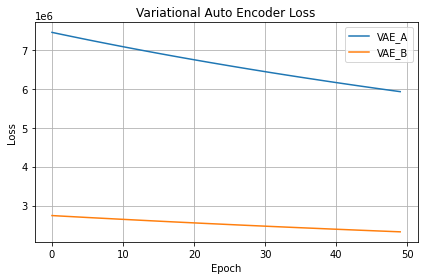

In [94]:
# VAE losses
plot_train_hist(train_hist, ['VAE_A', 'VAE_B'], 'Variational Auto Encoder Loss')

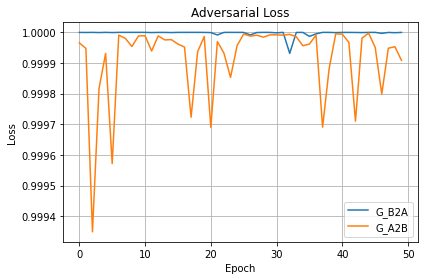

In [100]:
# Adversarial Generator losses
plot_train_hist(train_hist, ['G_B2A', 'G_A2B'], 'Adversarial Loss')

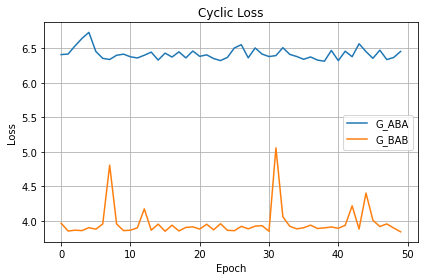

In [101]:
# Cyclic losses
plot_train_hist(train_hist, ['G_ABA', 'G_BAB'], 'Cyclic Loss')

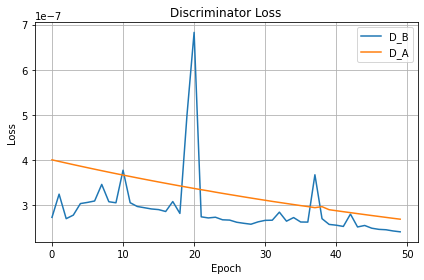

In [104]:
# Discriminators loss
plot_train_hist(train_hist, ['D_B', 'D_A'], 'Discriminator Loss')